In [100]:
import pandas as pd
import numpy as np

In [101]:
data = pd.read_csv('US_Accidents_Dec20_Updated.csv')
data.head()


,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,2,2019-05-21 08:29:55,2019-05-21 09:29:40,34.808868,-82.269157,34.808868,-82.269157,0.0,Accident on Tanner Rd at Pennbrooke Ln.,...,False,False,False,False,False,False,Day,Day,Day,Day
1,A-2,2,2019-10-07 17:43:09,2019-10-07 19:42:50,35.090080,-80.745560,35.090080,-80.745560,0.0,Accident on Houston Branch Rd at Providence Br...,...,False,False,False,False,False,False,Day,Day,Day,Day
2,A-3,2,2020-12-13 21:53:00,2020-12-13 22:44:00,37.145730,-121.985052,37.165850,-121.988062,1.4,Stationary traffic on CA-17 from Summit Rd (CA...,...,False,False,False,False,False,False,Night,Night,Night,Night
3,A-4,2,2018-04-17 16:51:23,2018-04-17 17:50:46,39.110390,-119.773781,39.110390,-119.773781,0.0,Accident on US-395 Southbound at Topsy Ln.,...,False,False,False,False,True,False,Day,Day,Day,Day
4,A-5,3,2016-08-31 17:40:49,2016-08-31 18:10:49,26.102942,-80.265091,26.102942,-80.265091,0.0,Accident on I-595 Westbound at Exit 4 / Pine I...,...,False,False,False,False,True,False,Day,Day,Day,Day


In [124]:
FL = data[data['State'] == 'FL']
FL.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
4,A-5,3,2016-08-31 17:40:49,2016-08-31 18:10:49,26.102942,-80.265091,26.102942,-80.265091,0.000,Accident on I-595 Westbound at Exit 4 / Pine I...,...,False,False,False,False,True,False,Day,Day,Day,Day
10,A-11,2,2019-12-20 08:20:12,2019-12-20 10:05:05,28.021709,-82.203583,28.021709,-82.203583,0.000,Restrictions due to accident on US-92 at Bethl...,...,False,False,False,False,False,False,Day,Day,Day,Day
30,A-31,2,2020-12-24 03:08:00,2020-12-24 05:23:25,25.684458,-80.445924,25.684452,-80.446072,0.009,Incident on SW 88TH ST near SW 157TH AVE Drive...,...,False,False,False,False,True,False,Night,Night,Night,Night
43,A-44,2,2016-12-29 07:35:34,2016-12-29 08:05:17,28.698406,-82.451477,28.698406,-82.451477,0.000,Accident on County Hwy-480 Oak Park Blvd at Co...,...,False,False,False,False,False,False,Day,Day,Day,Day
50,A-51,2,2020-11-30 17:40:30,2020-11-30 18:38:00,26.613410,-80.068784,26.594618,-80.069313,1.299,Slow traffic on I-95 S from 10th Ave/Exit 64 (...,...,False,False,False,False,False,False,Night,Day,Day,Day


In [143]:
def accidents_ETL(accidents):
    
    #drop unnecessary columns
    dropthese = ['ID', 'End_Lat', 'End_Lng', 'End_Time',    'Description', 'Distance(mi)', 'Number', 'Street', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Start_Lat', 'Start_Lng', 'Nautical_Twilight', 'Astronomical_Twilight', 'Wind_Chill(F)']
    accidents = accidents.drop(columns = dropthese, axis = 1)

    #modify Start_Time to datetime so we can extract year, month, day, hour
    accidents['Start_Time'] = pd.to_datetime(accidents['Start_Time'])

    #extracting year, month, day, hour
    accidents['Year'] = pd.DatetimeIndex(accidents['Start_Time']).year
    accidents['Month'] = pd.DatetimeIndex(accidents['Start_Time']).month
    accidents['Day'] = pd.DatetimeIndex(accidents['Start_Time']).day
    accidents['Hour'] = pd.DatetimeIndex(accidents['Start_Time']).hour
    
    #drop unnecessary Start_Time column
    accidents = accidents.drop(['Start_Time'], axis=1)

    #remove expanded zip code value
    accidents2 = accidents['Zipcode'].str.split('-', expand=True)
    accidents['Zipcode'] = accidents2[0]

    #Combining City/State and County/State to prevent wrong city or county aggregation
    accidents['City_State'] = accidents['City'].astype(str) + ',' + accidents['State'].astype(str)
    accidents['County_State'] = accidents['County'].astype(str) + ',' + accidents['State'].astype(str)
    accidents['City'] = accidents['City_State']
    accidents['County'] = accidents['County_State']
    accidents = accidents.drop(['City_State', 'County_State'], axis=1)

    #Replacing wind directions to cardinal 8 directions
    accidents['Wind_Direction'].replace('CALM', 'Calm', inplace=True)
    accidents['Wind_Direction'].replace(['ENE', 'NNE'], 'NE', inplace=True)
    accidents['Wind_Direction'].replace(['ESE', 'SSE'], 'SE', inplace=True)
    accidents['Wind_Direction'].replace(['WNW', 'NNW'], 'NW', inplace=True)
    accidents['Wind_Direction'].replace(['WSW', 'SSW'], 'SW', inplace=True)
    accidents['Wind_Direction'].replace('North', 'N', inplace=True)
    accidents['Wind_Direction'].replace('East', 'E', inplace=True)
    accidents['Wind_Direction'].replace('South', 'S', inplace=True)
    accidents['Wind_Direction'].replace('West', 'W', inplace=True)
    accidents['Wind_Direction'].replace('VAR', 'Variable', inplace=True)

    return(accidents)

In [144]:
accidents = accidents_ETL(FL)

In [145]:
accidents.head()

,Severity,Side,City,County,State,Zipcode,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),...,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Year,Month,Day,Hour
4,3,R,"Fort Lauderdale,FL","Broward,FL",FL,33324,84.2,84.0,29.92,10.0,...,False,False,True,False,Day,Day,2016,8,31,17
10,2,L,"Dover,FL","Hillsborough,FL",FL,33527,57.0,88.0,30.05,10.0,...,False,False,False,False,Day,Day,2019,12,20,8
30,2,R,"Miami,FL","Miami-Dade,FL",FL,33196,NaN,NaN,29.99,10.0,...,False,False,True,False,Night,Night,2020,12,24,3
43,2,R,"Homosassa,FL","Citrus,FL",FL,34446,60.8,94.0,30.10,0.2,...,False,False,False,False,Day,Day,2016,12,29,7
50,2,R,"Lake Worth,FL","Palm Beach,FL",FL,33461,72.0,91.0,29.86,10.0,...,False,False,False,False,Night,Day,2020,11,30,17


In [146]:
accidents.dtypes


Severity               int64
Side                  object
City                  object
County                object
State                 object
Zipcode               object
Temperature(F)       float64
Humidity(%)          float64
Pressure(in)         float64
Visibility(mi)       float64
Wind_Direction        object
Wind_Speed(mph)      float64
Precipitation(in)    float64
Weather_Condition     object
Amenity                 bool
Bump                    bool
Crossing                bool
Give_Way                bool
Junction                bool
No_Exit                 bool
Railway                 bool
Roundabout              bool
Station                 bool
Stop                    bool
Traffic_Calming         bool
Traffic_Signal          bool
Turning_Loop            bool
Sunrise_Sunset        object
Civil_Twilight        object
Year                   int64
Month                  int64
Day                    int64
Hour                   int64
dtype: object

In [163]:
test = accidents['Wind_Speed(mph)']

desc = test.describe()
nan = test.isnull().sum()
counts = test.value_counts()

print(f'Stats: {desc}')
print(f'NaN: {nan}')
print(f'Value Counts: {counts}')

Stats: count    246788.000000
mean          8.742507
std           5.496721
min           0.000000
25%           5.000000
50%           8.100000
75%          12.000000
max         984.000000
Name: Wind_Speed(mph), dtype: float64
NaN: 16512
Value Counts: 0.0      18980
6.0      13278
5.0      13270
7.0      13179
8.0      12624
         ...  
44.9         1
984.0        1
162.3        1
36.8         1
114.0        1
Name: Wind_Speed(mph), Length: 70, dtype: int64


<AxesSubplot:>

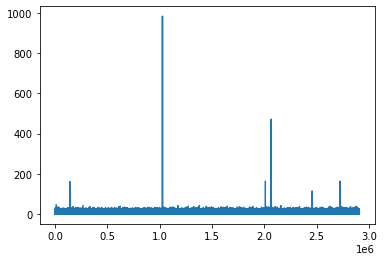

In [165]:
accidents['Wind_Speed(mph)'].plot()

In [203]:
pd.set_option('display.max_columns', None)
windless = data.loc[data['Wind_Speed(mph)'] >100]
windless_index = windless.index 
windless_index

Int64Index([   7568,   44601,   98678,  113481,  114990,  130254,  141570,
             184494,  226354,  280651,  429414,  504155,  565095,  578853,
             686534,  701330,  731545,  855615,  899620,  908590,  951840,
             985267, 1026920, 1046048, 1116030, 1170062, 1193137, 1228882,
            1236864, 1242572, 1253831, 1258047, 1272224, 1285057, 1323538,
            1353597, 1376353, 1492323, 1622316, 1654836, 1672632, 1721605,
            1733696, 1755302, 1791859, 1900821, 1913259, 1955616, 2009020,
            2039860, 2065934, 2092280, 2117253, 2121573, 2162169, 2174530,
            2233778, 2457520, 2500962, 2565827, 2577555, 2599815, 2684399,
            2702573, 2723181, 2736219, 2761125, 2832535],
           dtype='int64')

In [205]:
accidents = accidents.drop(windless_index.index, inplace=True)


AttributeError: 'Int64Index' object has no attribute 'index'

In [ ]:
accidents.drop(